# Evaluation Analysis for Recommender Output

In this section we will analyze and compare the generated recommendations and predictions from a predefined list of algorithms with the goal of assessing the performance of each algorithm with respect to a metric. In other words, we would rank the algorithms for each metric considered with respect to performance.

# Setup

Below are the list of packages required to successfully run the analysis. They are divided into partitions to signify their specific task.<br>
We need the pathlib package for working with files and folders

In [1]:
from pathlib import Path

We would use the pandas for analyzing and manipulating our data while seaborn and matplotlib are used for data visualization. statsmodels.graphics.gofplots and scipy.stats.shapiro are used for normality check. Scipy.stats.friedmanchisquare is a non-parametric test used to determine the statistical significance in metric results and the wilcoxon test is used for pairwise comparison of sample data.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations

Logging to show what's happening in LensKit routines:

In [3]:
from lenskit import util
util.log_to_notebook()

[   INFO] lenskit.util.log notebook logging configured


We will use lenskit for training, running, and evaluating recommender algorithms

In [4]:
from lenskit import topn
from lenskit.metrics.predict import rmse

# Load Data

We specify the dataset we will use for our analysis and the main directory from where we read the recommendation and prediction files. From the main directory we find all the directories associated with the dataset and then read the recommendation and predictions files from those directories.

In [5]:
dataset = "ml10m"

In [6]:
# Parameters
dataset = "ml100k"


In [7]:
output_root = Path("runs")

In [8]:
dirs = [fld for fld in output_root.glob(f'{dataset}-*')]

In [9]:
recs = []
for fld in dirs: 
    for file in fld.glob("recs-*"):
        rec = pd.read_csv(file, sep=',')
        rec["algorithm"] = fld.name.split("-")[1]
        recs.append(rec)

recs = pd.concat(recs, ignore_index=True)
recs = recs.astype({'algorithm': 'category'})
recs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565800 entries, 0 to 565799
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   item       565800 non-null  int64   
 1   score      565800 non-null  float64 
 2   user       565800 non-null  int64   
 3   rank       565800 non-null  int64   
 4   algorithm  565800 non-null  category
dtypes: category(1), float64(1), int64(3)
memory usage: 17.8 MB


In [10]:
rec_algos = recs['algorithm'].unique()
rec_algos

['ALS', 'Bias', 'IALS', 'II', 'Pop', 'UU']
Categories (6, object): ['ALS', 'Bias', 'IALS', 'II', 'Pop', 'UU']

In [11]:
preds = []
for fld in dirs:
    for file in fld.glob("pred-*"):
        pred = pd.read_csv(file, sep=',')
        pred["algorithm"] = fld.name.split("-")[1]
        preds.append(pred)

preds = pd.concat(preds, ignore_index=True)
preds = preds.astype({'algorithm': 'category'})
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23575 entries, 0 to 23574
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   user        23575 non-null  int64   
 1   item        23575 non-null  int64   
 2   rating      23575 non-null  float64 
 3   timestamp   23575 non-null  int64   
 4   prediction  23565 non-null  float64 
 5   algorithm   23575 non-null  category
dtypes: category(1), float64(2), int64(3)
memory usage: 944.3 KB


We need to load the test data so that we have the ground truths for computing accuracy 

In [12]:
split_root = Path("data-split")
split_dir = split_root / dataset

In [13]:
test = []
for file in split_dir.glob("test-*.csv.gz"):
    test.append(pd.read_csv(file, sep=','))

test = pd.concat(test, ignore_index=True)

# Top-N Metrics

The topn.RecListAnalysis class computes top-N metrics for recommendation list and takes care of making sure that the recommendations and ground truths are properly matched. Refer to the documentation for detailed explanation of the purpose for the RecListAnalysis class and how the analysis is done - https://lkpy.lenskit.org/en/stable/evaluation/topn-metrics.html 

In [14]:
rla = topn.RecListAnalysis()

rla.add_metric(topn.precision)
rla.add_metric(topn.recip_rank)
rla.add_metric(topn.ndcg)
results = rla.compute(recs, test, include_missing=True)
results = results.fillna(0)
results.head()

[   INFO] lenskit.topn analyzing 565800 recommendations (4715 truth rows)


[   INFO] lenskit.topn using rec key columns ['algorithm', 'user']


[   INFO] lenskit.topn using truth key columns ['user']


[   INFO] lenskit.topn numbering truth lists


[   INFO] lenskit.topn numbering rec lists


[   INFO] lenskit.topn collecting metric results


[   INFO] lenskit.topn measured 5658 lists in  232ms


[   INFO] lenskit.topn filling in missing user info (5658 initial rows)


level_1  nrecs  precision  recip_rank      ndcg  ntruth
algorithm user                                                         
ALS       7           0    100       0.01    0.500000  0.301792       5
          14          1    100       0.04    0.100000  0.243961       5
          16          2    100       0.01    0.019608  0.044586       5
          17          3    100       0.01    0.083333  0.099143       5
          24          4    100       0.00    0.000000  0.000000       5

We will reshape the 'results' dataframe by stacking the columns to index and then use the bar chart to visualize the performance of our algorithms with respect to the precision, reciprocal rank and ndcg metrics

In [15]:
pltData = (results.drop(columns=['nrecs', 'ntruth']).stack()).reset_index()
pltData.columns = ['algorithm', 'user', 'metric', 'val']
pltData.head()

,algorithm,user,metric,val
0,ALS,7,level_1,0.000000
1,ALS,7,precision,0.010000
2,ALS,7,recip_rank,0.500000
3,ALS,7,ndcg,0.301792
4,ALS,14,level_1,1.000000


We need to determine if the differences we observe in the performances of the algorithms for the various metrics are statistically significant. To achieve this, we will need to use either a parametric or non-parametric statistical test for comparing the differences. We will consider a parametric test - repeated ANOVA measure cause our sample groups are correlated.

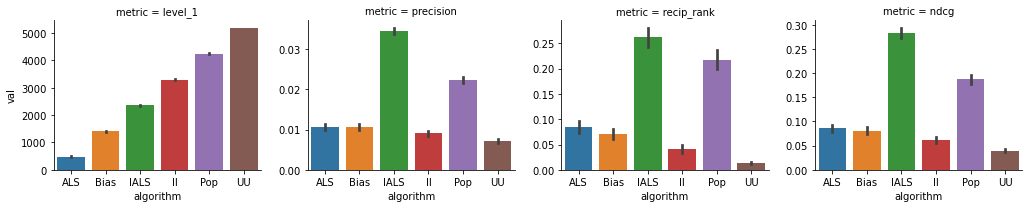

In [16]:
g = sns.catplot(x = "algorithm", y = "val", data = pltData, kind="bar", col = "metric", aspect=1.2, height=3, sharey=False)

### Statistical Testing

We will now examine these metrics in more detail and test for statistical significance.  Best practice for statistical testing for recommender systems is still a work in progress, but this method avoids most of the validity problems we know about.

The Friedman $\chi^2$ test will test the null hypothesis that there is no difference between algorithms in terms of their performance.

In [17]:
def metric_friedman(metric):
    groups = [df[metric] for a, df in results.groupby('algorithm')]

    stat, p = friedmanchisquare(*groups)
    return pd.Series({'stat': stat, 'p': p}, name=metric)

If the test detects significance, we have at least one pair of different algorithms - but which pairs?  Unfortunately, the good tests aren't readily available in scipy and friends, so we're going to take a conservative approch and perform pairwise Wilconxon signed-rank tests with a Bonferroni adjustment.

In [18]:
pairs = pd.DataFrame.from_records(combinations(rec_algos, 2), columns=['A1', 'A2'])
def am_wilcox(metric, p_scale = len(pairs)):
    def compute(df):
        vs1 = results.loc[df['A1'], metric]
        vs2 = results.loc[df['A2'], metric]
        diff = (vs1 - vs2).mean()
        stat, p = wilcoxon(vs1, vs2)
        return pd.Series({'diff': diff, 'stat': stat, 'p': p, 'adj_p': p * p_scale})
    scores = pairs.apply(compute, axis=1)
    return pairs.join(scores)

## Precision

In [19]:
metric_friedman('precision')

stat    2566.448386
p          0.000000
Name: precision, dtype: float64

This indicates a statistically significant difference exists - but where is it?

To answer that question, we need a post-hoc test. 

In [20]:
am_wilcox('precision').sort_values('diff', ascending=False)

,A1,A2,diff,stat,p,adj_p
11,IALS,UU,0.027338,1950.0,5.020471e-146,7.530707e-145
9,IALS,II,0.025504,4375.0,1.888412e-137,2.832618e-136
14,Pop,UU,0.015080,9669.0,2.572141e-116,3.858211e-115
10,IALS,Pop,0.012259,17384.0,1.047689e-89,1.571533e-88
4,ALS,UU,0.003457,11241.5,5.108602e-33,7.662903e-32
8,Bias,UU,0.003436,16811.0,4.329554e-27,6.494331e-26
13,II,UU,0.001835,18946.0,2.192785e-11,3.289177e-10
2,ALS,II,0.001622,14107.5,1.088990e-12,1.633485e-11
6,Bias,II,0.001601,21093.5,8.936320e-10,1.340448e-08
0,ALS,Bias,0.000021,31483.5,8.027451e-01,1.204118e+01


We can consider pairs with an adjusted $p$ value less than 0.05 (5.0e-2) to be statistically significant.  However, we have so many data points, the substance of significance is questionable.  Pay attention to the 'diff' column, which is the difference between A1 and A2 (how much A1 outperforms A2).

### nDCG

Now let's do the same for nDCG:

In [21]:
metric_friedman('ndcg')

stat    2123.644034
p          0.000000
Name: ndcg, dtype: float64

In [22]:
am_wilcox('ndcg').sort_values('diff', ascending=False)

,A1,A2,diff,stat,p,adj_p
11,IALS,UU,0.244295,2450.0,1.047782e-151,1.571673e-150
9,IALS,II,0.222729,15959.0,1.042509e-133,1.563764e-132
14,Pop,UU,0.148184,10033.0,5.275428e-134,7.913142e-133
10,IALS,Pop,0.096111,108683.0,3.731257e-41,5.596886e-40
4,ALS,UU,0.046022,21218.0,2.024207e-66,3.036311e-65
8,Bias,UU,0.041360,27725.5,3.247128e-58,4.870692e-57
2,ALS,II,0.024456,49100.0,3.449377e-29,5.174066e-28
13,II,UU,0.021566,45767.0,5.831325e-26,8.746987e-25
6,Bias,II,0.019794,61510.0,3.158119e-19,4.737179e-18
0,ALS,Bias,0.004662,104417.0,3.428635e-01,5.142953e+00


### Reciprocal Rank

We'll do this also for reciprocal rank (what is aggregated to compute MRR):

In [23]:
metric_friedman('recip_rank')

stat    1877.569828
p          0.000000
Name: recip_rank, dtype: float64

In [24]:
am_wilcox('recip_rank').sort_values('diff', ascending=False)

,A1,A2,diff,stat,p,adj_p
11,IALS,UU,0.248085,6256.5,1.108716e-145,1.663074e-144
9,IALS,II,0.221021,39675.5,1.236022e-102,1.854033e-101
14,Pop,UU,0.203907,8810.5,2.354491e-135,3.531736e-134
4,ALS,UU,0.070534,17186.0,3.845260e-73,5.767891e-72
8,Bias,UU,0.057195,18832.5,1.339341e-71,2.009012e-70
10,IALS,Pop,0.044178,159091.0,1.541038e-06,2.311556e-05
2,ALS,II,0.043469,48383.0,2.699226e-28,4.048840e-27
6,Bias,II,0.030131,60277.5,6.835116e-20,1.025267e-18
13,II,UU,0.027064,38413.0,4.005928e-34,6.008893e-33
0,ALS,Bias,0.013338,104877.0,8.492244e-01,1.273837e+01


## Prediction RMSE

We will also look at the prediction RMSE.

In [25]:
user_rmse = preds.groupby(['algorithm', 'user']).apply(lambda df: rmse(df['prediction'], df['rating']))
user_rmse = user_rmse.reset_index(name='RMSE')

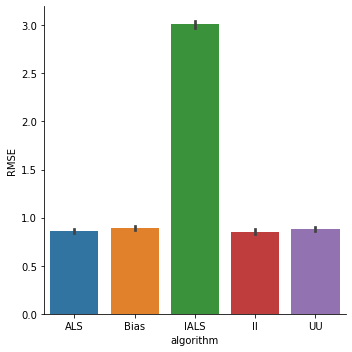

In [26]:
sns.catplot(x='algorithm', y='RMSE', data=user_rmse, kind='bar')